# 迴歸模型的評估

在試圖縮小軍方誤差的過程中會遇到一些問題
* 變數的單位量級距導致梯度遞減不均
* 隨機切割訓練驗證樣本所產生的變異
* 高次方項變數的過擬合

## 標準化

#### 為何需要標準化？
艾姆斯房價資料集中  
SalePrice數量級大約落在幾萬美元至幾十萬美元之間  
GrLivArea數量級大約落在幾千英畝  
不同的單位量級距，在同一個學習速率下，兩個係數收斂的速度差異很大  
可能導致一個係數已經收斂，但另一個仍然在緩慢抵達低點  
雖然成本含數遞減的速率已經平緩，迭代後所得到的係數卻與內建函數相差很大，尤其是常數項  

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

Thetas from Scikit-Learn:
[21905.13153846]
[[104.0984541]]
Thetas from manual gradient descent:
[[7.28896918e-02]
 [1.16260785e+02]]


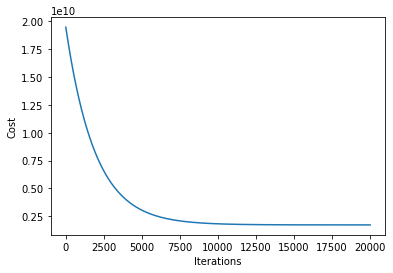

In [2]:
def compute_cost(X, y, thetas):
    m = X.shape[0]
    y_hat = np.dot(X, thetas)
    J = 1/(2*m)*np.sum(np.square(y_hat - y))
    return J

def gradient_descent(X, y, alpha=0.01, num_iters=1500):
    m = X.shape[0]
    J_history = np.zeros(num_iters)
    thetas = np.array([0, 0], dtype=float).reshape(-1, 1)
    for num_iter in range(num_iters):
        y_hat = np.dot(X, thetas)
        loss = y_hat - y
        gradient = np.dot(X.T, loss)
        thetas -= alpha*gradient/m
        J_history[num_iter] = compute_cost(X, y, thetas)
    return thetas, J_history

labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv")
train, validation = train_test_split(labeled, test_size=0.3, random_state=123)
X_train = train.loc[:, "GrLivArea"].values.reshape(-1, 1)
y_train = train.loc[:, "SalePrice"].values.reshape(-1, 1)
reg = LinearRegression()
reg.fit(X_train, y_train)
print("Thetas from Scikit-Learn:")
print(reg.intercept_)
print(reg.coef_)
ones = np.ones(X_train.shape[0], dtype=int).reshape(-1, 1)
X_train = np.concatenate([ones, X_train], axis=1)
thetas, J_history = gradient_descent(X_train, y_train, alpha=0.0000000001, num_iters=20000)
print("Thetas from manual gradient descent:")
print(thetas)
plt.plot(J_history)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

#### 標準化的使用
利用標準化(Normalization)的技巧來將變數的單位量級調整到同一個尺度上  
通常有兩種方法:  
1. Min Max Scaler : 將資料縮放到 [0,1]
2. Standard Scaler :  將資料縮放到符合常態分配、平均為0、標準差為1

In [3]:
from sklearn.preprocessing import StandardScaler


def standard_scaler(x):
    mean_x = x.mean()
    std_x = x.std()
    standard_x = (x - mean_x)/std_x
    return standard_x

labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv")
train, validation = train_test_split(labeled, test_size=0.3, random_state=123)
X_train = train.loc[:, "GrLivArea"].values.reshape(-1, 1)
y_train = train.loc[:, "SalePrice"].values.reshape(-1, 1)
reg = LinearRegression()
reg.fit(X_train, y_train)
print("Thetas from Scikit-Learn:")
print(reg.intercept_)
print(reg.coef_)
# Standardization
X_train_ss = standard_scaler(X_train)
y_train_ss = standard_scaler(y_train)
ones = np.ones(X_train.shape[0], dtype=int).reshape(-1, 1)
X_train_ss = np.concatenate([ones, X_train_ss], axis=1)
thetas, J_history = gradient_descent(X_train_ss, y_train_ss, alpha=0.001, num_iters=5000)
print("Standardized thetas from manual gradient descent:")
print(thetas)

Thetas from Scikit-Learn:
[21905.13153846]
[[104.0984541]]
Standardized thetas from manual gradient descent:
[[-2.77403671e-17]
 [ 6.88445467e-01]]


經過標準化後，就可以用一個較大的學習速率並在較少的迭代中讓係數收斂  
不過得到的係數仍是針對縮放過後的訓練資料，如果需要得到原本的係數，就要還原

In [4]:
# Rescaling
theta_0_pron = thetas[0, 0]
theta_1_pron = thetas[1, 0]
mu_y = y_train.mean()
sigma_y = y_train.std()
mu_X = X_train.mean()
sigma_X = X_train.std()
theta_0 = mu_y + sigma_y*theta_0_pron - sigma_y*mu_X*theta_1_pron/sigma_X
theta_1 = sigma_y*theta_1_pron/sigma_X
print("Rescaled thetas from manual gradient descent:")
print(theta_0)
print(theta_1)

Rescaled thetas from manual gradient descent:
22967.755672321568
103.39879673499419


## 評估迴歸模型的表現

均方誤差(Mean Squared Error, MSE)是迴歸模型的核心
實現方式有三種
1. 均方誤差的純量計算
2. 均方誤差的向量計算
3. 引用sklearn.metrics的mean_squared_error

In [5]:
#1. 均方誤差的純量計算
def get_mse(X_arr, y_arr, thetas):
    m = X_arr.size
    theta_0 = thetas[0, 0]
    theta_1 = thetas[1, 0]
    y_hat = theta_0 + theta_1*X_arr
    err = y_hat - y_arr
    se = np.sum(err**2)
    return se/m
#2. 均方誤差的向量計算
def get_mse_vectorized(X, y, thetas):
    m = X.shape[0]
    y_hat = np.dot(X, thetas)
    err = y_hat - y
    se = np.dot(err.T, err)
    return se[0, 0]/m

labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv")
train, validation = train_test_split(labeled, test_size=0.3, random_state=123)
X_train = train.loc[:, "GrLivArea"].values.reshape(-1, 1)
y_train = train.loc[:, "SalePrice"].values.reshape(-1, 1)
X_validation = validation.loc[:, "GrLivArea"].values.reshape(-1, 1)
ones = np.ones(X_validation.shape[0]).reshape(-1, 1)
X_validation = np.concatenate([ones, X_validation], axis=1)
y_validation = validation.loc[:, "SalePrice"].values.reshape(-1, 1)
reg = LinearRegression()
reg.fit(X_train, y_train)
theta_0 = reg.intercept_[0]
theta_1 = reg.coef_[0, 0]
thetas = np.array([theta_0, theta_1]).reshape(-1, 1)
mse = get_mse(validation.loc[:, "GrLivArea"].values, validation.loc[:, "SalePrice"].values, thetas)
vectorized_mse = get_mse_vectorized(X_validation, y_validation, thetas)
print("MSE: {:.0f}".format(mse))
print("MSE(vectorized): {:.0f}".format(vectorized_mse))

MSE: 2541490406
MSE(vectorized): 2541490406


In [6]:
#3. 引用sklearn.metrics的mean_squared_error
from sklearn.metrics import mean_squared_error

labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv")
train, validation = train_test_split(labeled, test_size=0.3, random_state=123)
X_train = train.loc[:, "GrLivArea"].values.reshape(-1, 1)
y_train = train.loc[:, "SalePrice"].values.reshape(-1, 1)
X_validation = validation.loc[:, "GrLivArea"].values.reshape(-1, 1)
y_validation = validation.loc[:, "SalePrice"].values.reshape(-1, 1)
reg = LinearRegression()
reg.fit(X_train, y_train)
y_hat = reg.predict(X_validation)
mse = mean_squared_error(y_validation, y_hat)
print("MSE: {:.0f}".format(mse))

MSE: 2541490406


## 精進評估

建立不同的迴歸模型來比較哪個較佳
---
#### 增加變數
**增加相關性也很高的變數**   
原本只有用 y = SalePrice，x = GrLivArea來建立模型  
現在用 y = SalePrice，x = GrLivArea、GarageArea來建立模型

In [7]:
labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv")
train, validation = train_test_split(labeled, test_size=0.3, random_state=123)
X_train_simple = train.loc[:, "GrLivArea"].values.reshape(-1, 1)
X_train_multiple = train.loc[:, ["GrLivArea", "GarageArea"]].values
y_train = train.loc[:, "SalePrice"].values.reshape(-1, 1)
X_validation_simple = validation.loc[:, "GrLivArea"].values.reshape(-1, 1)
X_validation_multiple = validation.loc[:, ["GrLivArea", "GarageArea"]].values
y_validation = validation.loc[:, "SalePrice"].values.reshape(-1, 1)
reg_simple = LinearRegression()
reg_multiple = LinearRegression()
reg_simple.fit(X_train_simple, y_train)
reg_multiple.fit(X_train_multiple, y_train)
y_hat_simple = reg_simple.predict(X_validation_simple)
y_hat_multiple = reg_multiple.predict(X_validation_multiple)
mse_simple = mean_squared_error(y_validation, y_hat_simple)
mse_multiple = mean_squared_error(y_validation, y_hat_multiple)
print("MSE of simple linear regression: {:.0f}".format(mse_simple))
print("MSE of multiple linear regression: {:.0f}".format(mse_multiple))

MSE of simple linear regression: 2541490406
MSE of multiple linear regression: 1930533820


從MSE的降低，可以發現增加GarageArea之後，迴歸模型在驗證資料上的預測表現更好  

---
#### 建立次方項
**將線性迴歸模型延伸應用至非線性迴歸模型**  
可以用 sklearn.preprocessing 中的 PolynomialFeatures 實現  

---
先繪製 Year Built 與 SalePrice 的散佈圖  

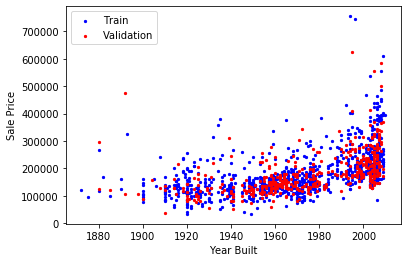

In [8]:
labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv")
train, validation = train_test_split(labeled, test_size=0.3, random_state=123)
plt.scatter(train["YearBuilt"], train["SalePrice"], s=5, c="b", label="Train")
plt.scatter(validation["YearBuilt"], validation["SalePrice"], s=5, c="r", label="Validation")
plt.xlabel("Year Built")
plt.ylabel("Sale Price")
plt.legend(loc="upper left")
plt.show()

建立出變數的平方項加入迴歸模型
再繪製一次項與二次項的迴歸模型

X_train with degree=2:
[[1.000000e+00 1.996000e+03 3.984016e+06]
 [1.000000e+00 1.940000e+03 3.763600e+06]
 [1.000000e+00 1.967000e+03 3.869089e+06]
 ...
 [1.000000e+00 1.968000e+03 3.873024e+06]
 [1.000000e+00 1.972000e+03 3.888784e+06]
 [1.000000e+00 1.941000e+03 3.767481e+06]]
MSE with degree=1: 4223063920
MSE with degree=2: 3769969724


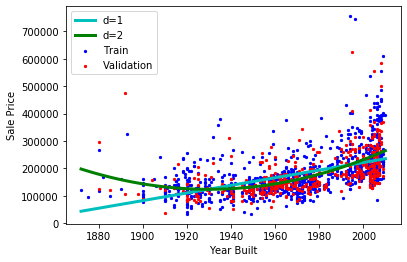

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures #建立出次方項
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv")
train, validation = train_test_split(labeled, test_size=0.3, random_state=123)
X_train = train.loc[:, "YearBuilt"].values.reshape(-1, 1)
X_validation = validation.loc[:, "YearBuilt"].values.reshape(-1, 1)
X_train_d2 = PolynomialFeatures(2).fit_transform(X_train)
print("X_train with degree=2:")
print(X_train_d2)
X_validation_d2 = PolynomialFeatures(2).fit_transform(X_validation)
y_train = train.loc[:, "SalePrice"].values.reshape(-1, 1)
y_validation = validation.loc[:, "SalePrice"].values.reshape(-1, 1)
reg_d1 = LinearRegression()
reg_d1.fit(X_train, y_train)
y_hat = reg_d1.predict(X_validation)
mse_d1 = mean_squared_error(y_validation, y_hat)
print("MSE with degree=1: {:.0f}".format(mse_d1))
reg_d2 = LinearRegression()
reg_d2.fit(X_train_d2, y_train)
y_hat = reg_d2.predict(X_validation_d2)
mse_d2 = mean_squared_error(y_validation, y_hat)
print("MSE with degree=2: {:.0f}".format(mse_d2))
X_arr_d1 = np.linspace(labeled["YearBuilt"].min(), labeled["YearBuilt"].max()).reshape(-1, 1)
X_arr_d2 = PolynomialFeatures(2).fit_transform(X_arr_d1)
y_arr_d1 = reg_d1.predict(X_arr_d1)
y_arr_d2 = reg_d2.predict(X_arr_d2)
plt.scatter(train["YearBuilt"], train["SalePrice"], s=5, c="b", label="Train")
plt.scatter(validation["YearBuilt"], validation["SalePrice"], s=5, c="r", label="Validation")
plt.plot(X_arr_d1, y_arr_d1, c="c", linewidth=3, label="d=1")
plt.plot(X_arr_d1, y_arr_d2, c="g", linewidth=3, label="d=2")
plt.xlabel("Year Built")
plt.ylabel("Sale Price")
plt.legend(loc="upper left")
plt.show()

由結果可知 加入變數平方項後，模型的MSE降低了，可以說有平方項的迴歸模型更相似於目標  
接下來的問題則是:  加入立方項、四次方項或者更高次方，是否會有更好的結果？ 
可以用運迴圈計算 一次到十次，不同次方項模型的MSE  

Best degree: 2


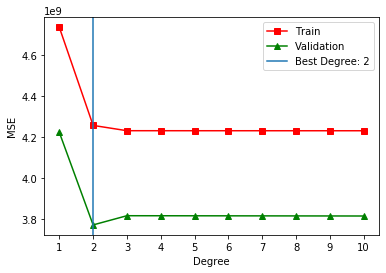

In [10]:
from sklearn.preprocessing import PolynomialFeatures
def get_best_degree(X_train, y_train, X_validation, y_validation, d=10):
    degrees = range(1, d+1)
    mse_train_arr = np.zeros(d)
    mse_validation_arr = np.zeros(d)
    for degree in degrees:
        X_train_poly = PolynomialFeatures(degree).fit_transform(X_train)
        X_validation_poly = PolynomialFeatures(degree).fit_transform(X_validation)
        reg = LinearRegression()
        reg.fit(X_train_poly, y_train)
        y_hat = reg.predict(X_train_poly)
        mse_train = mean_squared_error(y_train, y_hat)
        y_hat = reg.predict(X_validation_poly)
        mse_validation = mean_squared_error(y_validation, y_hat)
        mse_train_arr[degree - 1] = mse_train
        mse_validation_arr[degree - 1] = mse_validation
    best_degree = mse_validation_arr.argmin() + 1
    return mse_train_arr, mse_validation_arr, best_degree

labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv")
train, validation = train_test_split(labeled, test_size=0.3, random_state=123)
X_train = train.loc[:, "YearBuilt"].values.reshape(-1, 1)
X_validation = validation.loc[:, "YearBuilt"].values.reshape(-1, 1)
y_train = train.loc[:, "SalePrice"].values.reshape(-1, 1)
y_validation = validation.loc[:, "SalePrice"].values.reshape(-1, 1)
d = 10
mse_train_arr, mse_validation_arr, best_degree = get_best_degree(X_train, y_train, X_validation, y_validation, d=10)
print("Best degree: {}".format(best_degree))
degrees = range(1, d+1)
plt.plot(degrees, mse_train_arr, c="red", marker="s", label="Train")
plt.plot(degrees, mse_validation_arr, c="g", marker="^", label="Validation")
plt.xticks(degrees)
plt.axvline(best_degree, label="Best Degree: {}".format(best_degree))
plt.legend(loc="upper right")
plt.xlabel("Degree")
plt.ylabel("MSE")
plt.show()

由結果可知二次項為最佳模型，不過這是在固定隨機種子的情況下  
如果取消隨機種子的設定，會有不同結果 ，如下

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def get_best_degree(X_train, y_train, X_validation, y_validation, d=10):
  degrees = range(1, d+1)
  mse_train_arr = np.zeros(d)
  mse_validation_arr = np.zeros(d)
  for degree in degrees:
    X_train_poly = PolynomialFeatures(degree).fit_transform(X_train)
    X_validation_poly = PolynomialFeatures(degree).fit_transform(X_validation)
    reg = LinearRegression()
    reg.fit(X_train_poly, y_train)
    y_hat = reg.predict(X_train_poly)
    mse_train = mean_squared_error(y_train, y_hat)
    y_hat = reg.predict(X_validation_poly)
    mse_validation = mean_squared_error(y_validation, y_hat)
    mse_train_arr[degree - 1] = mse_train
    mse_validation_arr[degree - 1] = mse_validation
  best_degree = mse_validation_arr.argmin() + 1
  return mse_train_arr, mse_validation_arr, best_degree

def get_bd_history(labeled, num_iters=100):
  bd_history = np.zeros(num_iters)
  for num_iter in range(num_iters):
    train, validation = train_test_split(labeled, test_size=0.3)
    X_train = train.loc[:, "YearBuilt"].values.reshape(-1, 1)
    X_validation = validation.loc[:, "YearBuilt"].values.reshape(-1, 1)
    y_train = train.loc[:, "SalePrice"].values.reshape(-1, 1)
    y_validation = validation.loc[:, "SalePrice"].values.reshape(-1, 1)
    best_degree = get_best_degree(X_train, y_train, X_validation, y_validation)[2]
    bd_history[num_iter] = best_degree
  df = pd.DataFrame()
  df["bd_history"] = bd_history
  grouped = df.groupby("bd_history")
  return grouped.size().sort_values(ascending=False)

labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv")
get_bd_history(labeled)

bd_history
10.0    45
2.0     35
3.0     16
4.0      2
7.0      1
6.0      1
dtype: int64

進行100次的迭代後將最佳的次方項選擇記錄起來，發現切割訓練與驗證資料的隨機性，確實會影響驗證樣本的均方誤差    
使得參數的決定產生變異，那該如何消彌？  


## 交叉驗證
為了解決隨機切割標籤資料為訓練、驗證樣本而產生的變異，可以使用交叉驗證(Cross Validation)的技巧  
具體作法:  
將標籤資料分為 K 個相等大小的區塊，輪流讓其中 K-1 個區塊作為訓練資料、一個區塊作為驗證資料  
然後將 K 次的 MSE平均作為最後參考的MSE  
可以用sklearn.model_selection  中的 KFold 實現

Best degree: 5


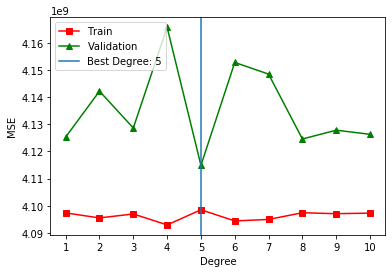

In [12]:
from sklearn.model_selection import KFold


def get_best_degree(X_labeled, y_labeled, k=5, d=10):
    kf = KFold(n_splits=k, shuffle=True)
    degrees = range(1, d+1)
    mse_train_avg_arr = np.zeros(d)
    mse_validation_avg_arr = np.zeros(d)
    for degree in degrees:
        mse_train_arr = []
        mse_validation_arr = []
        for train_idx, valid_idx in kf.split(X_labeled):
            X_train, X_validation = X_labeled[train_idx], X_labeled[valid_idx]
            y_train, y_validation = y_labeled[train_idx], y_labeled[valid_idx]
            X_train_poly = PolynomialFeatures(d).fit_transform(X_train)
            X_validation_poly =  PolynomialFeatures(d).fit_transform(X_validation)
            reg = LinearRegression()
            reg.fit(X_train_poly, y_train)
            y_hat = reg.predict(X_train_poly)
            mse_train = mean_squared_error(y_train, y_hat)
            y_hat = reg.predict(X_validation_poly)
            mse_validation = mean_squared_error(y_validation, y_hat)
            mse_train_arr.append(mse_train)
            mse_validation_arr.append(mse_validation)
        mse_train_avg_arr[degree - 1] = np.array(mse_train_arr).mean()
        mse_validation_avg_arr[degree - 1] = np.array(mse_validation_arr).mean()
    best_degree = mse_validation_avg_arr.argmin() + 1
    return mse_train_avg_arr, mse_validation_avg_arr, best_degree

labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv")
X_labeled = labeled.loc[:, "YearBuilt"].values.reshape(-1, 1)
y_labeled = labeled.loc[:, "SalePrice"].values.reshape(-1, 1)
mse_train_avg_arr, mse_validation_avg_arr, best_degree = get_best_degree(X_labeled, y_labeled)
print("Best degree: {}".format(best_degree))
d = 10
degrees = range(1, d+1)
plt.plot(degrees, mse_train_avg_arr, c="r", marker="s", label="Train")
plt.plot(degrees, mse_validation_avg_arr, c="g", marker="^", label="Validation")
plt.xticks(degrees)
plt.axvline(best_degree, label="Best Degree: {}".format(best_degree))
plt.legend(loc="upper left")
plt.xlabel("Degree")
plt.ylabel("MSE")
plt.show()

## 正規化
當模型提高次方項後，可能會造成過擬合，可以用正規化(Regularzation)來避免  
核心精神是在成本函數增加一個懲罰項(penalty)  
常見的正規化模型: Ridge  
可以用 sklearn.linear_model 中的 Ridge() 來實現  
--- 
先比較幾個不同的正規化程度下，各係數的大小以及迴歸模型的外觀  

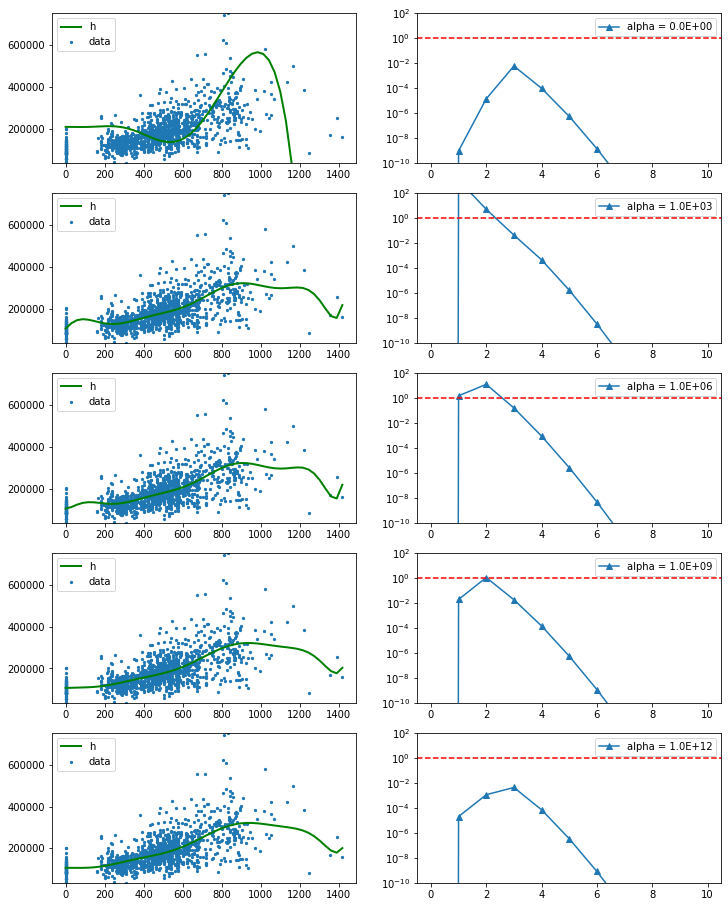

In [13]:
from sklearn.linear_model import Ridge


def plot_functions(labeled, regressor, d, ax):
    X_arr = np.linspace(labeled["GarageArea"].min(), labeled["GarageArea"].max()).reshape(-1, 1)
    X_arr_poly = PolynomialFeatures(d).fit_transform(X_arr)
    y_arr = regressor.predict(X_arr_poly)
    ax.scatter(labeled["GarageArea"], labeled["SalePrice"], s=5, label="data")
    ax.plot(X_arr, y_arr, c="g", linewidth=2, label="h")
    ax.set_ylim(labeled["SalePrice"].min(), labeled["SalePrice"].max())
    ax.legend(loc="upper left")

def plot_coefficients(regressor, ax, alpha):
    coef = regressor.coef_.ravel()
    ax.semilogy(np.abs(coef), marker='^', label="alpha = {:.1E}".format(alpha))
    ax.set_ylim((1e-10, 1e2))
    ax.axhline(y=1, ls="--", color="r")
    ax.legend(loc='upper right')
  
labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv")
X = labeled.loc[:, "GarageArea"].values.reshape(-1, 1)
y = labeled.loc[:, "SalePrice"].values.reshape(-1, 1)
degree = 10
X_poly = PolynomialFeatures(degree).fit_transform(X)
X_train, X_validation, y_train, y_validation = train_test_split(X_poly, y, test_size=0.3, random_state=123)
# 正規化係數 alpha
alphas = [0, 1e3, 1e6, 1e9, 1e12]
# Visualization
fig, axes = plt.subplots(5, 2, figsize=(12, 16))
for i, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    ax = axes[i, 0]
    plot_functions(labeled, ridge, d=degree, ax=ax)
    ax = axes[i, 1]
    plot_coefficients(ridge, ax=ax, alpha=alpha)
plt.show()

由結果看出，隨著正規化程度提高，函數會趨近平滑、係數也變小  